In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
import xgboost as xgb
import shap

pd.set_option('display.max_rows', 20)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/jeremybalch/opt/anaconda3/envs/medical_ai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jeremybalch/opt/anaconda3/envs/medical_ai/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/jeremybalch/opt/anaconda3/envs/medical_ai/lib/python3.11/site-packages/visions/backends/shared/nan_handling.py:50: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to

In [2]:
burn_data = pd.read_csv('/Users/jeremybalch/Dropbox (UFL)/Projects/Burn/data/burn_full_v2.csv')

In [3]:
burn_data.head()

,Column1,Study_ID,Transfused,Age,TBSA,2nd_degree,3rd_degree,ICU_LOS,Hosp_LOS,Dispo,...,Preop_Hb,Excised,Grafted,Case_length_minutes,RBC_Volume,FFP_Volume,Plt_Volume,Cryo_Volume,Total_blood_volume_transfused,RTOR
0,153,1140-034,0,35,11.0,10.00,1.00,0,5,1,...,13.5,0.0,0,86,0,0,0,0,0,1
1,142,1140-016,0,44,1.0,0.00,1.00,0,3,1,...,13.3,1.0,1,64,0,0,0,0,0,1
2,252,17,0,57,0.5,0.25,0.25,0,7,1,...,NaN,5.0,4,47,0,0,0,0,0,2
3,180,1140-067,0,66,1.0,0.00,1.00,0,1,1,...,14.6,8.0,8,64,0,0,0,0,0,1
4,226,4,0,41,0.5,0.00,0.50,0,3,1,...,NaN,15.0,15,41,0,0,0,0,0,1


In [4]:
# Create a new column 'RBC_units' by dividing 'RBC_Volume' by 350 and rounding to the nearest integer, drop Transfused == 0
burn_data['RBC_units'] = (burn_data['RBC_Volume'] / 350).round().astype(int)
burn_data['RBC_units'] = burn_data['RBC_units'].clip(upper=4)

print(burn_data.columns.to_list())

['Column1', 'Study_ID', 'Transfused', 'Age', 'TBSA', '2nd_degree', '3rd_degree', 'ICU_LOS', 'Hosp_LOS', 'Dispo', 'OR_Date', 'Preop_Hb', 'Excised', 'Grafted', 'Case_length_minutes', 'RBC_Volume', 'FFP_Volume', 'Plt_Volume', 'Cryo_Volume', 'Total_blood_volume_transfused', 'RTOR', 'RBC_units']


## Exploratory Data Analysis

In [5]:
# burn_data_clean = burn_data[['Age', 'Hosp_LOS', '2nd_degree', '3rd_degree', 'Preop_Hb', 'Excised', 
#                              'Grafted', 'Case_length_minutes', 'RTOR', 'Transfused', 'RBC_units']]

# df = burn_data_clean.copy()
# profile = ProfileReport(df, title="Pandas Profiling Report")
# profile.to_file('/Users/jeremybalch/Desktop/burn_report.html')

## Preprocessing - Multiclass Classification Project

In [6]:
# Select relevant columns
X_clean = burn_data[['Age', 'Hosp_LOS', '2nd_degree', '3rd_degree', 'Preop_Hb', 'Excised', 'Grafted', 'Case_length_minutes', 'RTOR']]
y_clean = burn_data['RBC_units']

In [7]:
# Assuming X_clean is your features and y_clean is the target variable (RBC_units)
# First, split into training (60%) and temporary data (40%) with stratification
train_X, temp_X, train_y, temp_y = train_test_split(X_clean, y_clean, test_size=0.4, stratify=y_clean, random_state=42)

# Now, split the temporary data into validation (20%) and test (20%) sets with stratification
val_X, test_X, val_y, test_y = train_test_split(temp_X, temp_y, test_size=0.5, stratify=temp_y, random_state=42)

In [8]:
# Impute Missing Values

#Instantiate the imputer
mice_imputer = IterativeImputer(random_state=42)

# Apply MICE imputation on train data for the specified columns
train_X[['Preop_Hb', 'Excised']] = mice_imputer.fit_transform(train_X[['Preop_Hb', 'Excised']])

# Apply MICE imputation on validation and test data for the specified columns
val_X[['Preop_Hb', 'Excised']] = mice_imputer.transform(val_X[['Preop_Hb', 'Excised']])
test_X[['Preop_Hb', 'Excised']] = mice_imputer.transform(test_X[['Preop_Hb', 'Excised']])

In [9]:
# Instantiate the scaler
scaler = StandardScaler()

# Fit on training data and transform it
train_X_scaled = scaler.fit_transform(train_X)

# Only transform the validation and test data
val_X_scaled = scaler.transform(val_X)
test_X_scaled = scaler.transform(test_X)

# Models

###     Decision Tree

In [ ]:
# Define the hyperparameters and their possible values
param_grid = {
    'max_depth': list(range(1, 21)),
    'criterion': ['gini', 'entropy'],
    'max_features': list(range(1, train_X_scaled.shape[1] + 1)) + ['auto', 'sqrt', 'log2']
}

# Instantiate the decision tree classifier
tree = DecisionTreeClassifier(random_state=42)

# Set up grid search with cross-validation
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy', return_train_score=True)

# Fit the model to the training data
grid_search.fit(train_X_scaled, train_y)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [11]:
print(best_params)
print(best_score)

{'criterion': 'gini', 'max_depth': 6, 'max_features': 5}
0.6249462365591398


In [12]:
# Instantiate the model with the best hyperparameters
best_tree = DecisionTreeClassifier(**best_params, random_state=42)
best_tree.fit(train_X_scaled, train_y)

# Evaluate on the validation set
val_predictions = best_tree.predict(val_X_scaled)
val_accuracy = accuracy_score(val_y, val_predictions)

# Evaluate on the test set
test_predictions_tree = best_tree.predict(test_X_scaled)
test_accuracy = accuracy_score(test_y, test_predictions_tree)

val_accuracy, test_accuracy


(0.5490196078431373, 0.5686274509803921)

### k-nearest neighbors

In [13]:
from sklearn.neighbors import KNeighborsClassifier

# Define the hyperparameters and their possible values
param_grid_knn = {
    'n_neighbors': list(range(1, 51)),  # testing values of k from 1 to 50
    'weights': ['uniform', 'distance'],  # uniform weights vs inverse distance weighting
    'metric': ['euclidean', 'manhattan']  # distance metrics
}

# Instantiate the kNN classifier
knn = KNeighborsClassifier()

# Set up grid search with cross-validation
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', return_train_score=True)

# Note: Replace "train_X_scaled" and "train_y" with your actual scaled training data and labels
grid_search_knn.fit(train_X_scaled, train_y)

# Get the best parameters from the grid search
best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_

best_params_knn, best_score_knn



({'metric': 'euclidean', 'n_neighbors': 16, 'weights': 'distance'},
 0.6509677419354838)

In [14]:
# Instantiate the kNN model with the best hyperparameters
best_knn = KNeighborsClassifier(**best_params_knn)
best_knn.fit(train_X_scaled, train_y)

# Evaluate on the validation set
val_predictions_knn = best_knn.predict(val_X_scaled)
val_accuracy_knn = accuracy_score(val_y, val_predictions_knn)

# Evaluate on the test set
test_predictions_knn = best_knn.predict(test_X_scaled)
test_accuracy_knn = accuracy_score(test_y, test_predictions_knn)

val_accuracy_knn, test_accuracy_knn


(0.5882352941176471, 0.6470588235294118)

### SVM

In [15]:
from sklearn.svm import SVC

# Define the hyperparameters and their possible values
param_grid_svm = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],  # only relevant for 'poly' kernel
    'gamma': ['scale', 'auto']
}

# Instantiate the SVM classifier
svm = SVC(random_state=42)

# Set up grid search with cross-validation
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy', return_train_score=True)

# Note: Replace "train_X_scaled" and "train_y" with your actual scaled training data and labels
grid_search_svm.fit(train_X_scaled, train_y)

# Get the best parameters from the grid search
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_

best_params_svm, best_score_svm



({'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'},
 0.6518279569892473)

In [16]:
# Instantiate the SVM model with the best hyperparameters
best_svm = SVC(**best_params_svm)
best_svm.fit(train_X_scaled, train_y)

# Evaluate on the validation set
val_predictions_svm = best_svm.predict(val_X_scaled)
val_accuracy_svm = accuracy_score(val_y, val_predictions_svm)

# Evaluate on the test set
test_predictions_svm = best_svm.predict(test_X_scaled)
test_accuracy_svm = accuracy_score(test_y, test_predictions_svm)

val_accuracy_svm, test_accuracy_svm


(0.5294117647058824, 0.5686274509803921)

### Xgboost 

In [ ]:


# # Define the hyperparameters and their possible values
# param_grid_xgb = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 4, 5, 6],  # smaller depths as part of aggressive pruning
#     'subsample': [0.7, 0.8, 0.9, 1],
#     'colsample_bytree': [0.7, 0.8, 0.9, 1],
#     'n_estimators': [50, 100, 150],
#     'objective': ['multi:softprob'],  # assuming multiclass classification
#     'gamma': [0, 0.1, 0.2]
# }

# # Instantiate the XGBoost classifier
# xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# # Set up grid search with cross-validation
# grid_search_xgb = GridSearchCV(xgb_classifier, param_grid_xgb, cv=5, scoring='accuracy', return_train_score=True)

# grid_search_xgb.fit(train_X_scaled, train_y)

# # Get the best parameters from the grid search
# best_params_xgb = grid_search_xgb.best_params_
# best_score_xgb = grid_search_xgb.best_score_

# # Uncomment the above lines and execute them on your actual dataset to get the best hyperparameters and their accuracy.
# best_params_xgb, best_score_xgb



In [17]:
best_params_xgb = {
    'colsample_bytree': 0.8,
    'gamma': 0,
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 50,
    'objective': 'multi:softprob',
    'subsample': 0.7
}


# Instantiate the XGBoost model with the best hyperparameters
best_xgb = xgb.XGBClassifier(**best_params_xgb, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
best_xgb.fit(train_X_scaled, train_y)

# Evaluate on the validation set
val_predictions_xgb = best_xgb.predict(val_X_scaled)
val_accuracy_xgb = accuracy_score(val_y, val_predictions_xgb)

# Evaluate on the test set
test_predictions_xgb = best_xgb.predict(test_X_scaled)
test_accuracy_xgb = accuracy_score(test_y, test_predictions_xgb)

val_accuracy_xgb, test_accuracy_xgb


`use_label_encoder` is deprecated in 1.7.0.


(0.6274509803921569, 0.6666666666666666)

### Neural Network

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim


In [36]:
# Define the neural network architecture
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 64)  # Second fully connected layer
        self.fc3 = nn.Linear(64, output_dim)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Adjust classes for multiclass
input_dim = train_X_scaled.shape[1]
output_dim = 5  #adjust for max 5 units pRBCs 0-4

# Convert data to PyTorch tensors
train_X_tensor = torch.tensor(train_X_scaled, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y, dtype=torch.long)
val_X_tensor = torch.tensor(val_X_scaled, dtype=torch.float32)
val_y_tensor = torch.tensor(val_y.values, dtype=torch.long)

# Instantiate the model, loss function, and optimizer
model = SimpleNN(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [40]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0, path='checkpoint.pth'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pth'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [41]:
# Initialize the EarlyStopping class
early_stopping = EarlyStopping(patience=10, verbose=True)

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(train_X_tensor)
    loss = criterion(outputs, train_y_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Compute the validation loss
    with torch.no_grad():
        val_outputs = model(val_X_tensor)
        val_loss = criterion(val_outputs, val_y_tensor)

    # Call EarlyStopping
    early_stopping(val_loss, model)

    # Break out of the loop if early stopping condition is met
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')

# Evaluate the model on the validation set
with torch.no_grad():
    val_outputs = model(val_X_tensor)
    _, predicted = torch.max(val_outputs.data, 1)
    val_accuracy = (predicted == val_y_tensor).sum().item() / val_y_tensor.size(0)
    print(f'Validation Accuracy: {val_accuracy:.4f}')


Validation loss decreased (inf --> 1.017560).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 6 out of 10
EarlyStopping counter: 7 out of 10
EarlyStopping counter: 8 out of 10
EarlyStopping counter: 9 out of 10
Epoch [10/100], Training Loss: 0.6645, Validation Loss: 1.0233
EarlyStopping counter: 10 out of 10
Early stopping
Validation Accuracy: 0.5686


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report


def compute_multiclass_metrics(true_values, predicted_values):
    report = classification_report(true_values, predicted_values, output_dict=True)
    accuracy = report['accuracy']
    macro_precision = report['macro avg']['precision']
    macro_recall = report['macro avg']['recall']
    macro_f1 = report['macro avg']['f1-score']
    
    return accuracy, macro_precision, macro_recall, macro_f1

# Example: Compute metrics for each model
metrics_decision_tree = compute_multiclass_metrics(test_y, test_predictions_tree)  # replace with your actual predictions
metrics_knn = compute_multiclass_metrics(test_y, test_predictions_knn)
metrics_svm = compute_multiclass_metrics(test_y, test_predictions_svm)
metrics_xgb = compute_multiclass_metrics(test_y, test_predictions_xgb)

# For PyTorch Neural Network
with torch.no_grad():
    nn_outputs = model(torch.tensor(test_X_scaled, dtype=torch.float32))
    _, nn_predictions = torch.max(nn_outputs.data, 1)
    nn_predictions = nn_predictions.numpy()
metrics_nn = compute_multiclass_metrics(test_y, nn_predictions)

# Compile metrics into a table
metrics_table_multiclass = pd.DataFrame({
    'Metric': ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1'],
    'Decision Tree': metrics_decision_tree,
    'KNN': metrics_knn,
    'SVM': metrics_svm,
    'XGBoost': metrics_xgb,
    'Neural Network': metrics_nn
})

metrics_table_multiclass



Metric	Decision Tree	KNN	SVM	XGBoost	Neural Network
0	Accuracy	0.568627	0.647059	0.568627	0.666667	0.607843
1	Macro Precision	0.531349	0.428182	0.369979	0.492490	0.363919
2	Macro Recall	0.502273	0.481385	0.396861	0.508225	0.446861
3	Macro F1	0.504570	0.445524	0.381299	0.500000	0.400096

In [39]:
metrics_table_multiclass.to_csv('/Users/jeremybalch/Desktop/metrics.csv')

In [ ]:
def plot_error_learning_curve_subplot(ax, estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Error Rate")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    # Convert scores to error rates
    train_error_rates = 1 - np.mean(train_scores, axis=1)
    test_error_rates = 1 - np.mean(test_scores, axis=1)
    
    train_std = np.std(train_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    ax.grid()
    
    ax.fill_between(train_sizes, train_error_rates - train_std, train_error_rates + train_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_error_rates - test_std, test_error_rates + test_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_error_rates, 'o-', color="r", label="Training Error")
    ax.plot(train_sizes, test_error_rates, 'o-', color="g", label="Test Error")
    
    ax.legend(loc="best")

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Plot error learning curves in 2x2 subplots
plot_error_learning_curve_subplot(axs[0, 0], best_tree, "Error Learning Curve (Decision Tree)", train_X_scaled, train_y, cv=5)
plot_error_learning_curve_subplot(axs[0, 1], best_knn, "Error Learning Curve (kNN)", train_X_scaled, train_y, cv=5)
plot_error_learning_curve_subplot(axs[1, 0], best_svm, "Error Learning Curve (SVM)", train_X_scaled, train_y, cv=5)
plot_error_learning_curve_subplot(axs[1, 1], best_xgb, "Error Learning Curve (XGBoost)", train_X_scaled, train_y, cv=5)


fig.suptitle("Error Rates for Multiclass Prediction", fontsize=16, y=1.03)
plt.tight_layout()
plt.show()


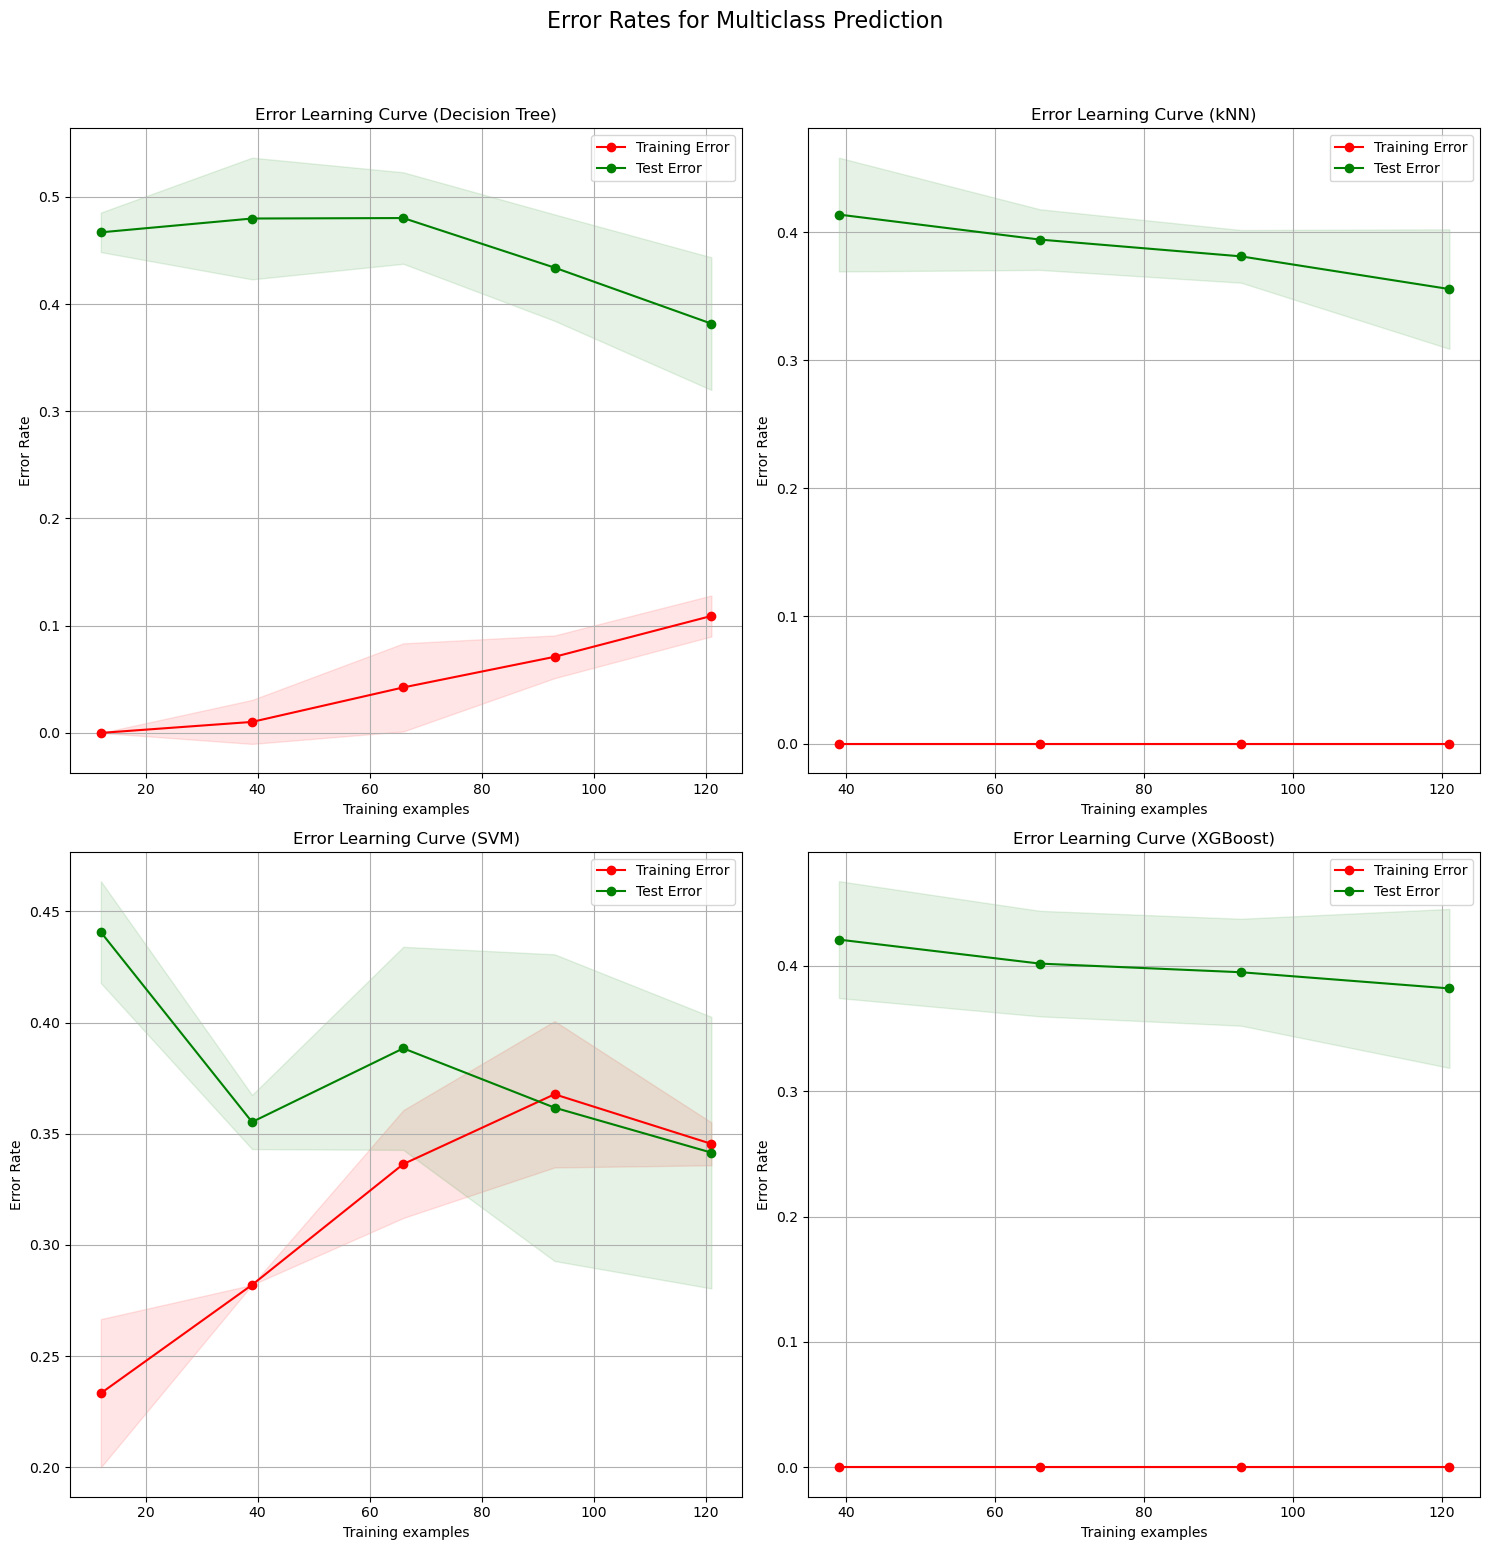

In [26]:
feature_labels = X_clean.columns.tolist()


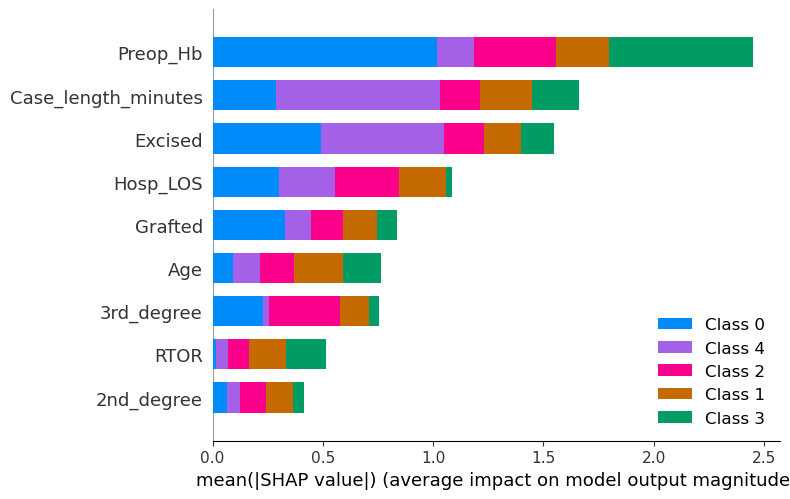

In [31]:
import shap

# Initialize the JS visualization code (this is required for SHAP's visualization tools)
shap.initjs()
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(val_X_scaled[:100])
shap.summary_plot(shap_values, val_X_scaled[:100], feature_names=feature_labels)


